# Homework 1: Numpy, Scipy, Pandas

### Due Monday Feb 5, 2018 @ 2pm


## #0: Get set up with your environment to work on and submit homework

a. Create a new homework repository at github

<img src="data/screenshot_1.png">

Name your repo something sensible (e.g., python-ay250-homeworks). Given your Berkeley affiliation you should be able to get private repos if you'd like.

<img src="data/screenshot_2.png">


b. Clone this repo locally and make a directory for this week's homework:

```bash
cd /class/directories ## this will be different on your machine...whereever you want to keep your work.

# change <username> to your github username:
git clone https://github.com/<username>/python-ay250-homework.git
cd python-ay250-homework
mkdir hw_1
echo "hw_1 README" >> hw_1/README.md
git add hw_1/README.md
git commit hw_1/README.md -m "added hw_1 directory"
git push
```

c. Copy this notebook into your `hw_1` folder from a local version of the python-seminar repo

```bash
cd /class/directories
git clone https://github.com/profjsb/python-seminar.git 
cd python-seminar
git pull
cp -r Homeworks/hw_1/* /class/directories/python-ay250-homework/hw_1/
```

d. Get working! Be sure to check in your work as often as you'd like

```bash
cd /class/directories/python-ay250-homework
git add hw_1/<whatever>
git commit <whatever> -m "this is a check in"
```

e. To submit your work, go to this form to register your homework Repo URL (https://goo.gl/forms/4DTPxonYBAxmfxJG2). If you've made your repo private, you'll need to add us as collaborators to the repo.  Our Github handles are `@profjsb` and `@chelseaharris`.

## #1:  Super-resolution imaging 

Obtaining several snapshots of the same scene, from microscopes to telescopes, is useful for the postprocessing increase of signal to noise: by summing up imaging data we can effectively beat down the noise. Interestingly, if we image the same scene from different vistas we can also improve the clarity of the combined image. Being able to discern features in a scene from this combination effort is sometimes called super-resolution imaging.

Here, we'll combine about 4 seconds of a shaky video to reveal the statement on a license plate that is not discernable in any one frame.

<img src="Data/im2-1.png">

A tarball of the data is at: https://drive.google.com/open?id=0B4vIeCR-xYNnbXFJTTVlVnpUZkk

```bash
tar -xvzf homework1_data.tgz  # do NOT check this files into git...
```

**Problem 1** Read in each image into a `numpy` array. Resize each frame to be 3 times larger in each axis (ie. 9 times larger images). Using `scipy.signal.fftconvolve` find the offsets of each frame with respect to the first frame. Report those offsets to 2 decimal places. 

   - Hint1: you'll need to figure out how to resize a numpy array
   - Hint2: you'll want to reverse the second image when doing the convolution: `scipy.signal.fftconvolve(im1, im2[::-1, ::-1])`
   - Hint3: you'll need to figure out how to identify the peak of the fft convolution to find the offsets between images

In [1]:
# imports
import os
from skimage import io
from scipy.ndimage.interpolation import zoom
from scipy.signal import fftconvolve
import numpy as np
from scipy.ndimage.interpolation import shift
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 2D Gaussian fitting method borrowed from: http://scipy-cookbook.readthedocs.io/items/FittingData.html
#    Does not rotate Guassian so not fully robust, but if a small enough region is used this should be a small error

from scipy import optimize

def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [4]:
rel_path = 'data/'
im_files = [fl for fl in os.listdir(rel_path) if 'im2' in fl] # not important that they be in order

# load first image as greyscale, trim off top and bottom, and triple the size along each axis
im1 = zoom(io.imread(rel_path + im_files[0], as_grey=True)[55:235,:], 3)#[200:700,:]

# remove mean
im1 -= np.mean(im1)

# convolve im1 with itself and find rough coords of ctr
im1c = fftconvolve(im1, im1[::-1,::-1], mode = 'same')
im1_ctr_rough = np.array(np.unravel_index(im1c.argmax(), im1c.shape))

# find refined coordinates of center by fitting 2D guassian to find coords of peak
#   NB: Gaussian is not rotated, but the introduced error is small because the fit is done close to the center
data = im1c[(im1_ctr_rough[0]-20):(im1_ctr_rough[0]+20), (im1_ctr_rough[1]-40):(im1_ctr_rough[1]+40)]
params = fitgaussian(data)
(height, x, y, width_x, width_y) = params
# x, y are coordinates from corner of smaller box cemtered at rough center, so convert to image coordinates
im1_ctr = np.array(x - 20, y - 40) + np.array(im1_ctr_rough)

# load all other images (greyscale), trimmed, zoomed, and with mean removed
ims = np.zeros((np.shape(im1)[0], np.shape(im1)[1], len(im_files)-1))
for idx, val in enumerate(im_files[1:]):
    ims[:,:,idx] = zoom(io.imread(rel_path + val, as_grey=True)[55:235], 3)#[200:700,:]
    ims[:,:,idx] -= np.mean(ims[:,:,idx])

In [5]:
# find offsets from im1 (approach is the same as above)
offsets = np.zeros((2, len(im_files)-1))
for idx, val in enumerate(im_files[1:]):
    tmp = fftconvolve(im1, ims[::-1, ::-1, idx])
    tmp_ctr_rough = np.array(np.unravel_index(tmp.argmax(), tmp.shape))
    data = tmp[(tmp_ctr_rough[0]-20):(tmp_ctr_rough[0]+20), (tmp_ctr_rough[1]-40):(tmp_ctr_rough[1]+40)]
    params = fitgaussian(data)
    (height, x, y, width_x, width_y) = params
    tmp_ctr = np.array(x - 20, y - 40) + np.array(tmp_ctr_rough)
    offsets[:,idx] = tmp_ctr - im1_ctr

In [6]:
print('Offsets:')
for i in range(np.shape(offsets)[1]):
    print('{:.2f}, {:.2f}'.format(*offsets[:,i]))

Offsets:
122.85, 342.85
154.12, 332.12
326.03, 382.03
200.92, 412.92
269.50, 399.50
198.97, 495.97
160.25, 312.25
206.33, 336.33
107.40, 391.40
82.53, 358.53
145.66, 346.66
225.67, 398.67
122.35, 254.35
210.05, 391.05
159.90, 293.90
239.95, 440.95
275.05, 446.05
148.34, 399.34
148.20, 397.20
246.30, 297.30
153.86, 375.86
179.29, 277.29
186.54, 398.54
197.71, 367.71
187.68, 327.68
248.43, 440.43
130.25, 320.25
184.48, 462.48
187.79, 393.79
306.31, 380.31
269.57, 401.57
189.07, 238.07
177.30, 536.30
186.31, 357.31
236.22, 394.22
193.60, 379.60
158.13, 297.13
139.74, 363.74
287.75, 464.75
178.46, 303.46
146.80, 293.80
232.59, 457.59
131.48, 402.48
256.03, 398.03
210.34, 292.34
237.55, 401.55
129.07, 289.07
84.64, 321.64
307.96, 435.96
130.83, 279.83
246.75, 340.75
213.56, 275.56
241.49, 305.49
174.37, 378.37
247.58, 492.58
254.73, 343.73
265.75, 474.75
132.11, 407.11
297.42, 341.42
177.29, 453.29
132.22, 235.22
215.63, 423.63
138.30, 436.30
239.32, 385.32
274.27, 437.27
195.23, 343.23
198

**Problem 2** Shift each image to register the frames to the original (expanded in size) frame. You should, in general, be shifting by subpixel offsets. You might want to look at `scipy.ndimage.interpolation.shift`

In [7]:
# shift all images
shifted_ims = np.zeros(np.shape(ims))
for idx in range(np.shape(offsets)[1]):
    shifted_ims[:,:,idx] = shift(ims[:,:,idx], offsets[:,idx])

**Problem 3** Combine all the registered images to form a super-resolution image. What does the license plate read?

The license plate reads: IM A CAR


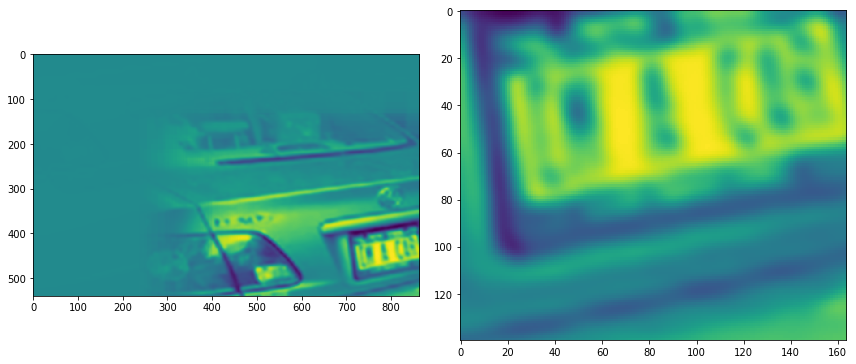

In [8]:
# add images together
super_im = np.sum(shifted_ims, axis=2) + im1

# plot added image and read license plate!
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(super_im)
ax[1].imshow(super_im[400:,700:])
plt.tight_layout()

print('The license plate reads: IM A CAR')

# #2: An elementary introduction to spectral audio compression

In this problem, we'll explore the very basics of audio compression in the spectral domain using numpy and scipy. We'll do a bit of visualization with matplotlib, but since that is covered later in the course, we'll provide those functions for you.

Audio compression is a large and complex topic, and the design of a format for compressed audio such as the popular [MP3](http://en.wikipedia.org/wiki/MP3) is too complex to cover in detail here. However, we will introduce the basic tools that most such compression formats use, namely:

1. Converting the input signal to the frequency domain by taking a Fast Fourier Transform (FFT).

2. Dropping information in the frequency domain, resulting in a smaller amount of data.

3. Reconstructing back the signal in the time domain from this smaller representation of the signal.

Steps 1 and 2 above are the 'encoding' part of signal compression, and step 3 is the 'decoding' part. For this reason, the tools that perform these steps are typically referred to as signal 'codecs', short for encoders/decoders.

Note that here we say 'signal': while MP3 is an audio format, the same ideas apply to the compression of digital images with formats such as JPEG and video.  Virtually all multimedia technologies we use today, from audio players to cell phones, digital cameras and YouTubeVideo, are based on sophisticated extensions and applications of these simple ideas.

Let's first load the plotting tools and importing some tools we'll need later:

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# we'll need some path manipulations later on
import os

We define a simple utility function to listen to audio files right in the browser:

In [10]:
def Audio(fname):
    """Provide a player widget for an audio file.
    
    Parameters
    ==========
    fname : string
      Filename to be played.
      
    Warning
    =======
    
    Browsers cache audio very aggressively. If you change an
    audio file on disk and are trying to listen to the  new version, you 
    may want to 
    """
    from IPython.display import HTML, display
    
    # Find out file extension and deduce MIME type for audio format
    ext = os.path.splitext(fname)[1].replace('.', '').lower()
    mimetype = 'audio/' + ('mpeg' if ext == 'mp3' else ext)
    
    tpl = """<p>{fname}:</p>
<audio controls>
    <source src="files/{fname}" type="{mimetype}">

Your browser does not support the Audio element; you can play 
<a href="files/{fname}">this file</a> manually.
</audio>
"""
    display(HTML(tpl.format(**locals())))

We also define a convenience wrapper around `plt.specgram`, [matplotlib's spectrogram function](http://matplotlib.org/api/mlab_api.html#matplotlib.mlab.specgram), with a colorbar and control over the color limits displayed. This will make it easier to compare across different signals with the same colors for all inputs.

In [11]:
def specgram_cbar(x, title=None, clim=(0, 80) ):
    """Plot spectrogram with a colorbar and range normalization.
    
    Call matplotlib's specgram function, with a custom figure size, 
    automatic colobar, title and custom color limits to ease 
    comparison across multiple figures.
    
    Parameters
    ==========
    x : array
      One-dimensional array whose spectrogram should be plotted.
      
    title : string
      Optional title for the figure.
      
    clim : 2-tuple
      Range for the color limits plotted in the spectrogram.
    """
    f = plt.figure(figsize=(10,3))
    plt.specgram(x, Fs=2)
    plt.colorbar()
    plt.clim(*clim)
    if title is not None:
        plt.title(title)
    plt.show()

**Problem 1**: Use the `Audio` function above to listen to the signal we will be experimenting with, a simple voice recording stored in the file `Homeworks/hw1/data/voice.wav`.

Note: if your browser doesn't support audio, you may try a different browser.   We've tested current versions of Chrome and Firefox, and it works OK with both.

In [12]:
# your code here
Audio('data/voice.wav')

**Problem 2**: Write a function to compress a 1-d signal by dropping a fraction of its spectrum. 

You can drop the smallest components by setting their values to zero.

*Hints*: 

- look at the `np.fft` module, keeping in mind that your input signal is real.
- look at the `argsort` method of numpy arrays.

In [13]:
def compress_signal(x, fraction):
    """Compress an input signal by dropping a fraction of its spectrum.
    
    Parameters
    ==========
    x : array
      1-d real array to be compressed
      
    fraction : float
      A number in the [0,1] range indicating which fraction of the spectrum
      of x should be zeroed out (1 means zero out the entire signal).
      
    Returns
    =======
    x_approx : array
      1-d real array reconstructed after having compressed the input.
    """
    
    # compute spectrum
    spec = np.fft.rfft(x)
    
    # get indices of smallest components of spectrum and truncate up to specified fraction of spectrum
    sm_ind = np.argsort(spec)[:int(fraction*len(spec))]
    
    # set selected smallest components to zero
    spec[sm_ind] = 0
    
    # return approximate array after inverse transforming
    return np.fft.irfft(spec)

As a quick visual check (not that this is *not* a formal test of correctness), experiment with a simple random signal by changing the compression ratio and plotting both the signal and the compressed version:

In [14]:
x = np.random.rand(128)

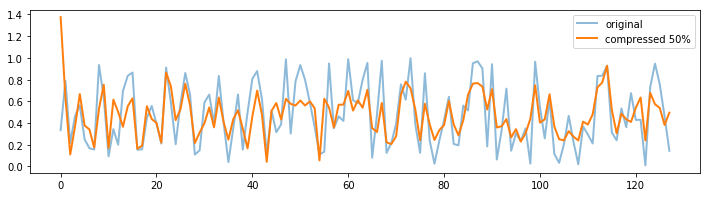

In [15]:
fraction = 0.5  # play changing this in the 0-1 range

xa = compress_signal(x, fraction)

plt.figure(figsize=(12,3))
plt.plot(x, alpha=0.5, lw=2, label='original')
plt.plot(xa, lw=2, label='compressed {0:.0%}'.format(fraction))
plt.legend();

**Problem 3**: Write a function that will compress an audio file by a dropping a fraction of its spectrum, writing the output to a new file.

If the input file is named `a.wav` and the compression fraction is 0.9, the output file should be named `a_comp_0.9.wav`.

*Hints:* 

- look at the `scipy.io` module for routines dealing with files in `wav` format.

- you may need to use the `astype` method of numpy arrays to get the correct data type for `wav` files.

In [20]:
from scipy.io import wavfile

def compress_wav(fname, fraction):
    """Compress an audio signal stored in an input wav file.
    
    The compressed signal is returned as a numpy array and automatically written 
    to disk to a new wav file.
    
    Parameters
    ==========
    fname : string
      Name of the input wav file
      
    fraction : float
      Fraction of input data to keep.
      
    Returns
    =======
    rate : int
      Bit rate of the input signal.

    x : array
      Raw data of the original input signal.
      
    x_approx : array
      Raw data of the compressed signal.
      
    new_fname : string
      Auto-generated filename of the compressed signal.
    """
    
    # read in rate and data
    rate, x = wavfile.read(fname)
    
    # get data for compressed signal taking care to cast the values back to the same type as was read in
    x_approx = compress_signal(x, fraction).astype(np.int16)
    
    # generate new fname
    new_fname = '{}_comp_{}.wav'.format(fname[:-4], fraction)
    
    # write file to disk
    wavfile.write(new_fname, rate, x_approx)
    
    # return requested items
    return rate, x, x_approx, new_fname

**Problem 4**: Study the effect of compressing the input file at different ratios: 0.1, 0.5, 0.75, 0.9, 0.95, 0.99.

Using the `OrderedDict` class from the [Python collections module](http://docs.python.org/2/library/collections.html#collections.OrderedDict), store the uncompressed signal as well as the compressed array and filename for each compression ratio.

You will create an `OrderedDict` called `voices`, with:

- keys: compression ratios
- values: pairs of (x, filename) where x is the compressed audio and filename is the name of the compressed file.

In [21]:
from collections import OrderedDict

# define constants
c_ratios = [0.1, 0.5, 0.75, 0.9, 0.95, 0.99]
fname = 'data/voice.wav'

# generate ordered dict
voices = OrderedDict()
for r in c_ratios:
    rate, x, x_approx, new_fname = compress_wav(fname, r)
    voices.update({r: (x_approx, new_fname)})

**Problem 5**: Loop over the `voices` dict, and for each one generate an audio player as well as a spectrogram.  Observe how the spectrogram changes, and listen to each file.  At what ratio do you stop understanding the recording?

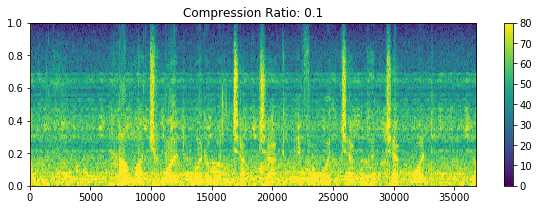

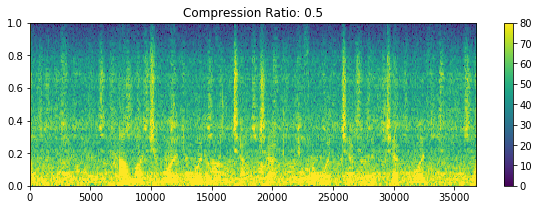

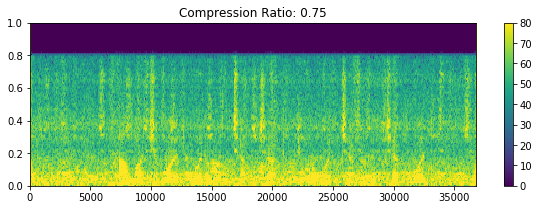

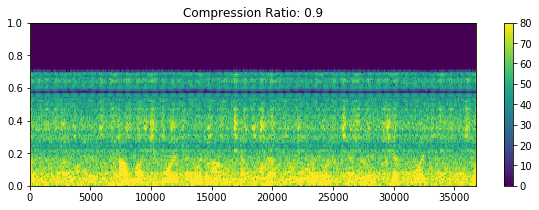

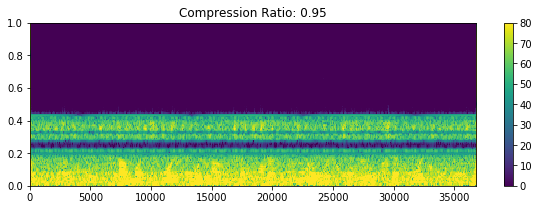

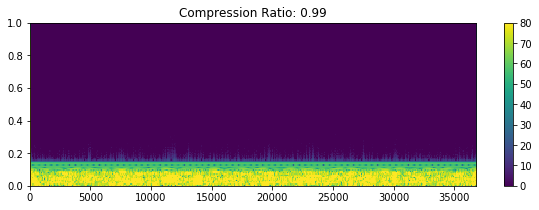

In [23]:
# iterate over keys in the ordered dict
for key in voices.keys():
    # generate audio player and spectrogram
    Audio(voices[key][1])
    specgram_cbar(voices[key][0], title = 'Compression Ratio: {}'.format(key))

In [24]:
print('Only at a compression of 0.99 did the message start to become undecipherable')

Only at a compression of 0.99 did the message start to become undecipherable


# #3: Armchair Astronomer

Often times, people act as good sensors of the physical universe. We can use Google Trends data to help us determine some fundamental parameters of the Solar System.

**Problem 1**: Using just the CSV file we created in the pandas lecture (`merged_data.csv`) and some frequency analysis tools in `scipy` to determine:

   - the number of days in a year
   - the period of the moon's orbit around the Earth
   
Hint: `from scipy.signal.spectral import lombscargle` (you'll want to normalize your signal so it has a mean of zero.)

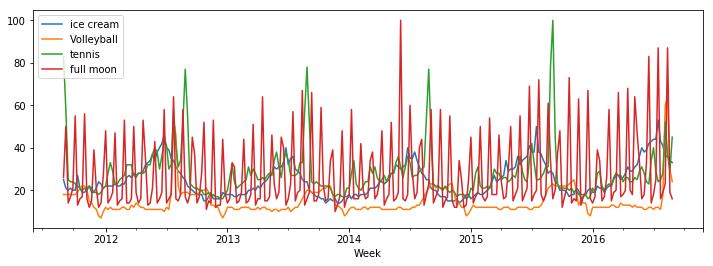

In [25]:
import pandas as pd
from scipy.signal.spectral import lombscargle

# load data using dates as indices and visualize it
md = pd.read_csv('data/merged_data.csv',index_col=0,parse_dates=[0])
md.plot(figsize = (12,4))

In [27]:
# we expect the searches for ice cream, tennis, and volleybal to peak roughly once per year (in summer)
# therefore we will work with each of them and compare
searches = ['ice cream', 'tennis', 'Volleyball']

# examine the given temporal range and observe the cadence is weeks:
print(md.index)

# convert weeks to a running count of days starting at zero
days = md.index.to_julian_date() - md.index.to_julian_date().min()
print(days)

DatetimeIndex(['2011-09-03', '2011-09-10', '2011-09-17', '2011-09-24',
               '2011-10-01', '2011-10-08', '2011-10-15', '2011-10-22',
               '2011-10-29', '2011-11-05',
               ...
               '2016-06-25', '2016-07-02', '2016-07-09', '2016-07-16',
               '2016-07-23', '2016-07-30', '2016-08-06', '2016-08-13',
               '2016-08-20', '2016-08-27'],
              dtype='datetime64[ns]', name='Week', length=261, freq=None)
Float64Index([   0.0,    7.0,   14.0,   21.0,   28.0,   35.0,   42.0,   49.0,
                56.0,   63.0,
              ...
              1757.0, 1764.0, 1771.0, 1778.0, 1785.0, 1792.0, 1799.0, 1806.0,
              1813.0, 1820.0],
             dtype='float64', name='Week', length=261)


Average of three measurements: 1 year = 368.46 days


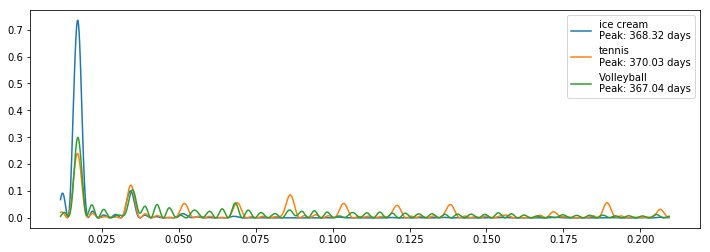

In [28]:
# use a range of (angular) frequencies ranging from approximately once every 1.5 years to once per month (in days)
freqs = np.linspace(1/(1.5*365), 1/30, 10000)
ang_freqs = 2*np.pi*freqs

# plot and store results
fig, ax = plt.subplots(1,1, figsize = (12,4))
measurements = []

# iterate through the searches and compute the periodogram, plot it, and compute frequency at which it peaks
for search in searches:
    # remove mean from the data
    pgram = lombscargle(days, md[search] - np.mean(md[search]), ang_freqs, normalize = True)
    ax.plot(ang_freqs, pgram, label = "{}\nPeak: {:.2f} days".format(search, 1/freqs[np.argmax(pgram)]))
    measurements.append(1/freqs[np.argmax(pgram)])
ax.legend()

print('Average of three measurements: 1 year = {:.2f} days'.format(np.mean(measurements)))

Period of moons orbit: 29.53 days


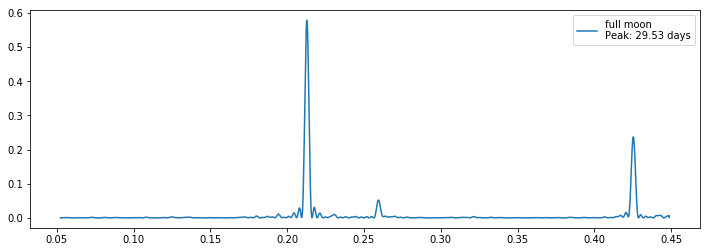

In [30]:
# perform the same procedure for the moon data

# use a range of (angular) frequencies ranging from approximately once every 4 months to once every 2 weeks (in days)
freqs = np.linspace(1/(4*30), 1/(2*7), 10000)
ang_freqs = 2*np.pi*freqs

# plot and store results
fig, ax = plt.subplots(1,1, figsize = (12,4))
pgram = lombscargle(days, md['full moon'] - np.mean(md['full moon']), ang_freqs, normalize = True)
ax.plot(ang_freqs, pgram, label = "{}\nPeak: {:.2f} days".format('full moon', 1/freqs[np.argmax(pgram)]))
ax.legend()

print('Period of moons orbit: {:.2f} days'.format(1/freqs[np.argmax(pgram)]))

# #4: Reproducing some insights about the Election

Nate ("not a genius, just a Bayesian") Silver writes often about polls and their utility of predicting elections. One of the things he emphasized during the 2016 campaign is that even "large" polls of people with a consistent lead for one candidate will show wild swings in any given window in time.

**Problem 1**: Using Pandas and `numpy`, try to reproduce this plot from a Nate Silver Tweet qualitatively using the same assumptions.

<img src="https://www.evernote.com/l/AUU-KkH3Z-lBdKokzCzVIUe53YZLQ9e_AuMB/image.png">

https://twitter.com/NateSilver538/status/769565612955824128

In [34]:
import datetime

def poll_sim(interviews_per_day = 200, n_days = 5, tot_days = 170, lead_bkgnd = 0.06, plot = True):

    # set random seed
    np.random.seed(1)

    # create array to hold tot_days worth of interview results
    results = np.zeros((tot_days, interviews_per_day))

    # populate with randomly drawn interview results
    for idx in range(tot_days):
        results[idx,:] = np.random.randint(0,high=2,size=interviews_per_day)

    # generate and populate array to hold lead results
    lead_results = np.zeros(tot_days - n_days)
    for idx in range(len(lead_results)):
        # select 5 contiguous days of interview results and compute percentage lead and add background lead
        tmp = results[idx:idx+5,:].flatten()
        lead_results[idx] = (len(tmp[tmp == 0]) - len(tmp[tmp == 1]))/len(tmp) + lead_bkgnd

    if plot is True:
        # create list of dates
        day_one = day_one = pd.to_datetime('2016-06-01')
        dates = [day_one + datetime.timedelta(day) for day in range(len(lead_results))]

        # put results into dataframe and plot
        results_df = pd.DataFrame(data=lead_results, index=dates, columns=['lead'])
        results_df.plot(color='m', figsize=(10,8), grid=True)
        
    return lead_results

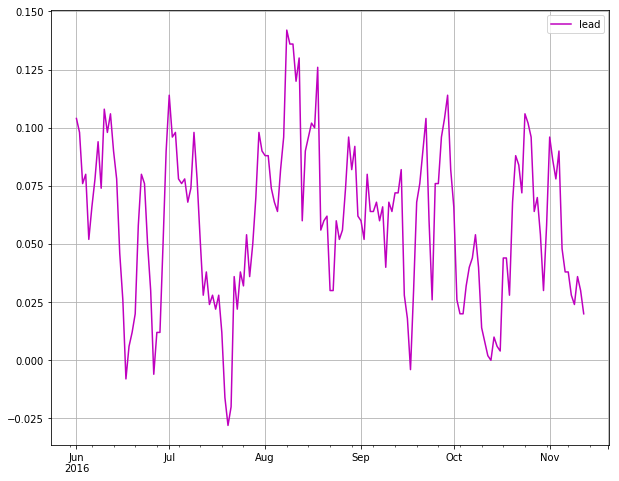

In [35]:
lead_results = poll_sim()

**Problem 2**: Clearly, even with a 6% point lead, there's a chance that this sort of poll would show the other person in the lead. How much would ahead (in percent) would a candidate need to be to have a tracking poll never show the other candidate to be ahead over the course of a year (in your simulation)?

In [37]:
# in order to never have the tracking poll above show the other candidate ahead, the lead would have to increase
#    by enough so that the lowest point was above the zero line

print('In order to never lose (in this simulation), the lead must be at least: {:.1f}%'.format(
    100*(0.06-np.min(lead_results))))

In order to never lose (in this simulation), the lead must be at least: 8.8%


**Problem 3**: With a 3 and 6% lead, how many people would need to be polled in 1 day to have the rolling 5-day poll result always show the leader ahead (over a year)?

In [38]:
# 3% test first, start with 200 people polled per day
npd = 200
cont = True
while cont:
    lr = poll_sim(interviews_per_day=npd, tot_days=365, lead_bkgnd=0.03, plot=False)
    if np.min(lr) > 0:
        print('With {} people polled per day for one year with a {}% lead, the leader will always be ahead.'.format(
        npd, 3))
        cont = False
    else:
        npd += 1

With 1911 people polled per day for one year with a 3% lead, the leader will always be ahead.


In [39]:
# 6% test start with 200 people polled per day
npd = 200
cont = True
while cont:
    lr = poll_sim(interviews_per_day=npd, tot_days=365, lead_bkgnd=0.06, plot=False)
    if np.min(lr) > 0:
        print('With {} people polled per day for one year with a {}% lead, the leader will always be ahead.'.format(
        npd, 6))
        cont = False
    else:
        npd += 1

With 594 people polled per day for one year with a 6% lead, the leader will always be ahead.
